<a href="https://colab.research.google.com/github/apssouza22/cnn-for-devs/blob/master/i-multitask-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## Multitask model and Transfer learning
In this session we are going to see how we can do multi-task learning in Pytorch.

Inpired by https://gist.github.com/yang-zhang/ec071ae4775c2125595fd80f40efb0d6#file-multi-face-ipynb


We will try to predict gender and race (both classification tasks) based on the image. Later we will also predict the age. Age will be a regression task and it is a bit more difficult

In this session will be the first time we will use transfer learning where we leverage from a model weights to initialize our model

We will download the [dataset from Kaggle](https://www.kaggle.com/jangedoo/utkface-new), therefore we will need a Kaggle API token. After signed up to Kaggle:

- Go to https://www.kaggle.com/account.(Click on your profile picture -> account) 
- Scroll down to the section of the page labelled API:
- Click on the “Create New API Token” button. This will download a fresh authentication token onto your machine.

In [1]:
# Upload the Kaggle API token 
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alexsandrosouza","key":"2b38e9c5ffc40264226eb5108cf2736c"}'}

In [2]:
# Steps required to download the Kaggle dataset
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download jangedoo/utkface-new  --unzip

 99% 329M/331M [00:13<00:00, 28.7MB/s]
100% 331M/331M [00:13<00:00, 26.0MB/s]


In [3]:
%matplotlib inline
from pathlib import Path

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from fastai import *
from fastai.vision import *
from torchvision import transforms
from fastai.vision.transform import get_transforms

In [4]:
p = Path('.')
images = list(p.glob('utkface_aligned_cropped/UTKFace/*.jpg'))
len(images)

23708

The labels of each face image is embedded in the file name, formatted like [age]_[gender]_[race]_[date&time].jpg

[age] is an integer from 0 to 116, indicating the age [gender] is either 0 (male) or 1 (female) [race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern). [date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace


In [5]:
images[:3]

[PosixPath('utkface_aligned_cropped/UTKFace/31_0_1_20170117130014250.jpg.chip.jpg'),
 PosixPath('utkface_aligned_cropped/UTKFace/26_0_0_20170113210127408.jpg.chip.jpg'),
 PosixPath('utkface_aligned_cropped/UTKFace/47_0_0_20170105173114291.jpg.chip.jpg')]

In [6]:
images = [image for image in images if len(str(image).split('/')[-1].split('_'))==4 and '__' not in str(image)]
len(images)

23705

In [7]:
# A handy function to look at the content of a dictionary.
def show_dct(dct, n=3):
    return dict(list(dct.items())[:n])

In [8]:
i2fn = images
image_dict = {image:i for i,image in enumerate(i2fn)}
show_dct(image_dict)

{PosixPath('utkface_aligned_cropped/UTKFace/26_0_0_20170113210127408.jpg.chip.jpg'): 1,
 PosixPath('utkface_aligned_cropped/UTKFace/31_0_1_20170117130014250.jpg.chip.jpg'): 0,
 PosixPath('utkface_aligned_cropped/UTKFace/47_0_0_20170105173114291.jpg.chip.jpg'): 2}

In [9]:
image_names = [os.path.basename(o) for o in images]
image_names[:3]

['31_0_1_20170117130014250.jpg.chip.jpg',
 '26_0_0_20170113210127408.jpg.chip.jpg',
 '47_0_0_20170105173114291.jpg.chip.jpg']

In [10]:
ages, genders, races = zip(*[image.split('_')[:3] for image in image_names])

In [11]:
ages = [int(o) for o in ages]
ages[:3]

[31, 26, 47]

In [12]:
gender_map = {'0': 'm', '1': 'f'}
genders = [gender_map[o] for o in genders]

genders[:3]

['m', 'm', 'm']

In [13]:
race_map = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
races = [race_map[int(o)] for o in races]
races[:3]

['Black', 'White', 'White']

In [14]:
Counter(genders)

Counter({'f': 11314, 'm': 12391})

In [15]:
Counter(races).most_common()

[('White', 10078),
 ('Black', 4526),
 ('Indian', 3975),
 ('Asian', 3434),
 ('Others', 1692)]

In [16]:
sorted(Counter(list(zip(races, genders))). items())

[(('Asian', 'f'), 1859),
 (('Asian', 'm'), 1575),
 (('Black', 'f'), 2208),
 (('Black', 'm'), 2318),
 (('Indian', 'f'), 1714),
 (('Indian', 'm'), 2261),
 (('Others', 'f'), 932),
 (('Others', 'm'), 760),
 (('White', 'f'), 4601),
 (('White', 'm'), 5477)]

In [17]:
df = pd.DataFrame({'img_name': images, 'age': ages, 'gender': genders, 'race': races})
df['is_train'] = np.random.choice(2, size=len(df), p=[0.2, 0.8])
df.head()

,img_name,age,gender,race,is_train
0,utkface_aligned_cropped/UTKFace/31_0_1_2017011...,31,m,Black,1
1,utkface_aligned_cropped/UTKFace/26_0_0_2017011...,26,m,White,0
2,utkface_aligned_cropped/UTKFace/47_0_0_2017010...,47,m,White,0
3,utkface_aligned_cropped/UTKFace/24_1_4_2017011...,24,f,Others,1
4,utkface_aligned_cropped/UTKFace/40_0_0_2017011...,40,m,White,1


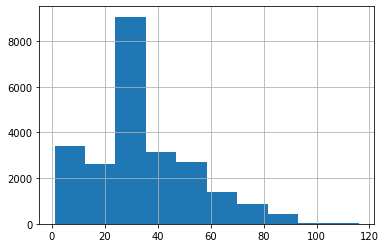

In [18]:
df.age.hist()

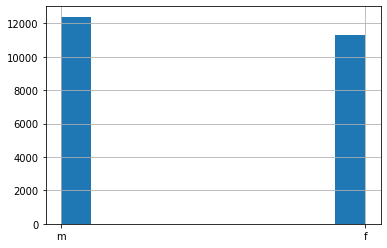

In [19]:
df.gender.hist()

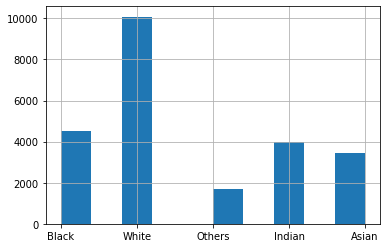

In [20]:
df.race.hist()

age: 23; gender: f; race: Asian


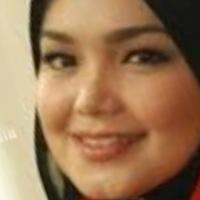

In [21]:
# Random picture. Notice that open_image is a fastai function that returns a fastai Image object.
index = np.random.choice(images)
i = image_dict[index]
print(f'age: {ages[i]}; gender: {genders[i]}; race: {races[i]}')
open_image(index)

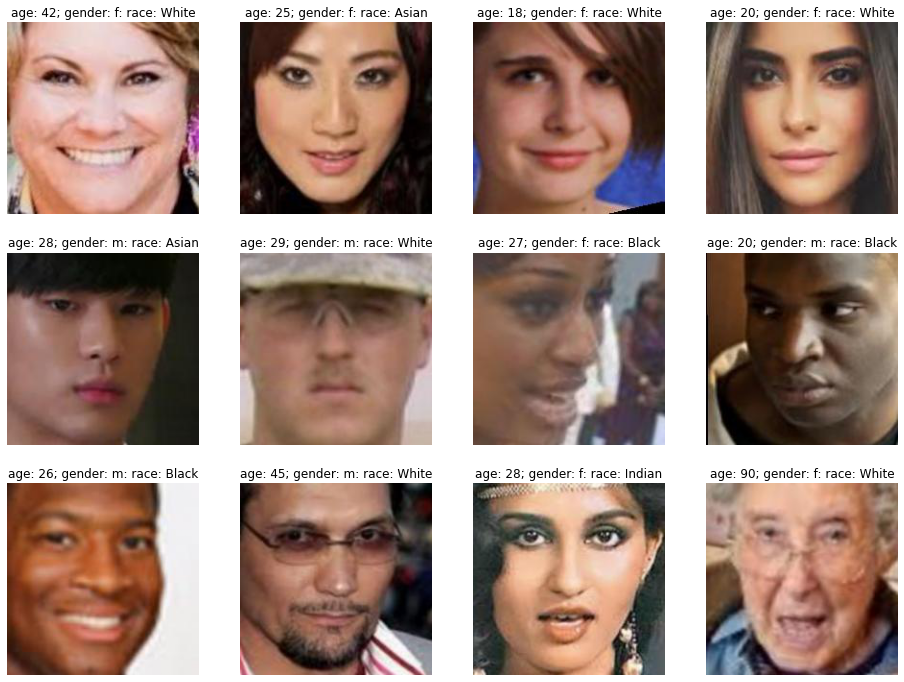

In [22]:
# A grid of random pictures.
nrows, ncols = 3, 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
images_sample = np.random.choice(images, nrows*ncols)

for j, idx in enumerate(images_sample):
    i = image_dict[idx]
    show_image(open_image(idx), axs[j//ncols, j%ncols])
    axs[j//ncols, j%ncols].set(title=f'age: {ages[i]}; gender: {genders[i]}: race: {races[i]}')

In [41]:
# Train model function, basically the same used in the PyTorch tutorials, we only added a function to calculate the accurancy depending on the type of the module(Single task or multitask)
def train_model(model, loss_func, accurancy_func, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  loss_log = []
  acc_log = []
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          loss = loss_func(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += accurancy_func(outputs,labels)
    
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      loss_log.append(epoch_loss)
      acc_log.append(epoch_acc.cpu().detach())
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  
  return model, {"loss": loss_log, "acc": acc_log}

## Single task model

We are going to start building a single task model to predict either the race or the gender based on an image, then later we will build a multi task model to predict both with the same model.

In [24]:
# Process the single task accurancy during training
def single_task_accurancy(outputs, labels):
  _, preds = torch.max(outputs, 1)
  return torch.sum(preds == labels.data)

# Return the prediction text when visualizing the model results
def single_prediction_text_fn(outputs, idx):
  _, preds = torch.max(outputs, 1)
  return classes[preds[idx]]

# Simple function to visualize the model result
def visualize_model(model, prediction_text_fn, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(prediction_text_fn(outputs, j)))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  

In [26]:
# Load the datasets for single task model
def load_data(df):
  def get_dataset(df, classes=None):
      return SingleTaskDataset(df.img_name, df[target], tfms = get_transforms()[0], classes=classes)

  train_ds = get_dataset(df[df.is_train==1], classes)
  valid_ds = get_dataset(df[df.is_train==0], classes)

  train_dl = DataLoader(train_ds, batch_size=512, shuffle=True, num_workers=2)
  valid_dl = DataLoader(valid_ds, batch_size=512, shuffle=True, num_workers=2)
  
  # i = np.random.choice(len(valid_ds))
  # valid_ds.show(i)

  dataloaders={"val" : valid_dl, "train": train_dl}
  dataset_sizes={"val" : len(valid_ds), "train": len(train_ds)}
  return dataloaders, dataset_sizes


In [27]:
#  Custom single task dataset
class SingleTaskDataset(Dataset):
    def __init__(self,img_path, img_label, tfms, classes, size=64):
        self.paths = np.array(img_path)
        self.tfms = tfms
        self.size = size
        self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet stats
        
        self.classes = classes

        self.class2idx = {v:k for k,v in enumerate(self.classes)}
        self.y = np.array([self.class2idx[o] for o in img_label], dtype=np.int64)

    def __len__(self): return len(self.paths)

    def __getitem__(self,idx):
        #dealing with the image
        img = PIL.Image.open(self.paths[idx]).convert('RGB')
        img = Image(pil2tensor(img, dtype=np.float32).div_(255))
        img = img.apply_tfms(self.tfms, size = self.size)
        img = self.norm(img.data)
        
        return img.data,  torch.tensor(int(self.y[idx]), dtype=torch.int64)

    def show(self,idx):
        x,y = self.__getitem__(idx)
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        img = ((x.numpy().transpose((1,2,0)) * stds + means) * 255).astype(np.uint8)
        plt.imshow(img)
        plt.title("{}".format(int(y.item())))

class SingleTaskModel(nn.Module):
	"""Single task model custom class"""

	def __init__(self, resnet34_model,out_features): # add conf file
		super(SingleTaskModel, self).__init__()
    
		for param in resnet34_model.parameters():
			param.requires_grad = False

		in_features = resnet34_model.fc.in_features
		self.resnet34_model=resnet34_model
		self.resnet34_model.fc = nn.Linear(in_features, 512)
		self.fc = nn.Linear(in_features=512, out_features=out_features)

	def forward(self,x):
		return  self.fc(self.resnet34_model(x))
  

In [28]:
# Here we can define if we want a model to predict gender or race
target = 'gender'
# target = 'race'
classes = sorted(set(df[target]))
classes

['f', 'm']

In [29]:
## Removing some bad data
idx1 = df[df.race == '20170109150557335.jpg.chip.jpg'].index
idx2 = df[df.race == '20170109142408075.jpg.chip.jpg'].index
idx3 = df[df.race == '20170116174525125.jpg.chip.jpg'].index
df = df.drop(idx1)
df = df.drop(idx2)
df = df.drop(idx3)
classes = sorted(set(df[target]))
classes

['f', 'm']

In [ ]:
resnet34_model = models.resnet34(pretrained=True)
resnet34_model

In [31]:
## Ignoring some user warning from pytorch
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [44]:
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import time
import copy

dataloaders, dataset_sizes = load_data(df)

model_ft = SingleTaskModel(resnet34_model, len(classes))
model_ft = model_ft.to(device)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)# Decay LR by a factor of 0.1 every 7 epochs
model_ft, history = train_model(model_ft, nn.CrossEntropyLoss(),  single_task_accurancy, optimizer_ft, exp_lr_scheduler, num_epochs=5)


Epoch 0/4
----------
train Loss: 0.6748 Acc: 0.5915
val Loss: 0.6073 Acc: 0.6774

Epoch 1/4
----------
train Loss: 0.5823 Acc: 0.6991
val Loss: 0.5757 Acc: 0.6951

Epoch 2/4
----------
train Loss: 0.5659 Acc: 0.7098
val Loss: 0.5505 Acc: 0.7206

Epoch 3/4
----------
train Loss: 0.5512 Acc: 0.7262
val Loss: 0.5462 Acc: 0.7372

Epoch 4/4
----------
train Loss: 0.5460 Acc: 0.7297
val Loss: 0.5465 Acc: 0.7317

Training complete in 6m 23s
Best val Acc: 0.737223


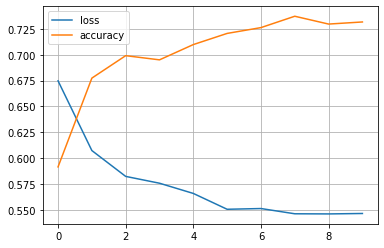

In [45]:
plt.plot(history["loss"], label='loss')
plt.plot(history["acc"], label='accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

In [46]:
set(dataloaders["val"].dataset.classes)

{'f', 'm'}

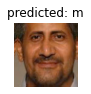

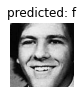

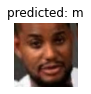

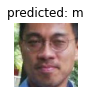

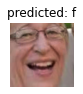

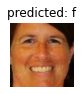

In [47]:
# Visualize model predictions
visualize_model(model_ft, single_prediction_text_fn)

## Multitask model 

Let's start build a multi task model to predict gender and race

In [48]:
class MultitaskDataset(Dataset):
    "`Dataset` for multi-label image classification."
    def __init__(
        self, 
        gender_ds: SingleTaskDataset,
        race_ds: SingleTaskDataset
      ):
        self.race_ds = race_ds
        self.gender_ds = gender_ds
        self.x = race_ds.paths
        
        self.classes_gender = gender_ds.classes
        self.classes_race = race_ds.classes

        self.y_gender = gender_ds.y
        self.y_race = race_ds.y
    
    def __len__(self): return len(self.x)

    def __getitem__(self,idx):
      x, y = self.gender_ds.__getitem__(idx) # interested only in the image(x) here, we could get it from race_ds as well
      return x,  torch.tensor([self.gender_ds.y[idx], self.race_ds.y[idx]]).float()

    
    def __repr__(self): return f'{type(self).__name__} of len {len(self)}'

    def show(self,idx):
      self.gender_ds.show(idx)
    

def get_dataset(df):
    return MultitaskDataset(
        SingleTaskDataset(df.img_name, df["gender"], tfms = get_transforms()[0], classes=sorted(set(df.gender))), 
        SingleTaskDataset(df.img_name, df["race"], tfms = get_transforms()[0], classes=sorted(set(df.race))), 
  )
    
train_ds = get_dataset(df[df.is_train==1])
valid_ds = get_dataset(df[df.is_train==0])
train_dl = DataLoader(train_ds, batch_size=512, shuffle=True, num_workers=2)
valid_dl = DataLoader(valid_ds, batch_size=512, shuffle=True, num_workers=2)

dataloaders={"val" : valid_dl, "train": train_dl}
dataset_sizes={"val" : len(valid_ds), "train": len(train_ds)}  

In [49]:
get_transforms()[0]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=Tr

In [50]:
valid_ds.classes_gender, valid_ds.classes_race

(['f', 'm'], ['Asian', 'Black', 'Indian', 'Others', 'White'])

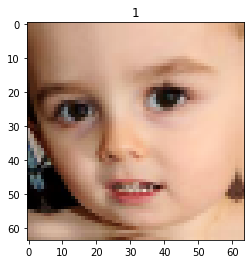

In [51]:
valid_ds.show(np.random.choice(len(valid_ds)))


In [52]:
# We need a spacial loss function for our multitask model 
def multitask_loss(outputs, target):
  cross_entropy = nn.CrossEntropyLoss()

  target_gender, target_race = target[:,0], target[:, 1]
  output_gender, output_race = outputs[0], outputs[1]

  loss_race = cross_entropy(output_race, target_race.long())
  loss_gender = cross_entropy(output_gender, target_gender.long())
  #the .16 and .44 is a result of experimenting different different values
  # gender has a smaller weight than race in the loss result
  return loss_gender/(.16) + loss_race/(.44) 

In [53]:
class MultiTaskModel(nn.Module):
	"""Custom multi task model class"""

	def __init__(self, resnet34_model): # add conf file
		super(MultiTaskModel, self).__init__()
	  
		# making sure we don't update the gradiente for the resnet model
		for param in resnet34_model.parameters():
			param.requires_grad = False

		num_ftrs = resnet34_model.fc.in_features
		self.resnet34_model=resnet34_model
		self.resnet34_model.fc = nn.Linear(num_ftrs, 512)
  
		# self.age = nn.Linear(in_features=512, out_features=1)
		self.race = nn.Linear(in_features=512, out_features=5)
		self.gender = nn.Linear(in_features=512, out_features=2)

	def forward(self,x):
		# age = self.age(self.resnet34_model(x))
		gender = self.gender(self.resnet34_model(x))
		race = self.race(self.resnet34_model(x))

		return gender, race

In [54]:
# Custom function to calculate the accurance for the multi task model
def multitask_accuracy(outputs, labels):
  _, preds_gender = torch.max(outputs[0], 1)
  _, preds_race = torch.max(outputs[1], 1)
    
  running_corrects = torch.sum(preds_gender == labels[:,0].data)
  running_corrects += torch.sum(preds_race == labels[:,1].data)
  return running_corrects


In [55]:
## Easier to debug running in the cpu
device = "cuda:0"
# device = "cpu"

In [59]:
resnet34 = models.resnet34(pretrained=True)
model_ft = MultiTaskModel(resnet34)
model_ft = model_ft.to(device)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)# Observe that all parameters are being optimized
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)# Decay LR by a factor of 0.1 every 7 epochs
model_ft, history = train_model(model_ft, multitask_loss, multitask_accuracy, optimizer_ft, exp_lr_scheduler, num_epochs=2)

Epoch 0/1
----------
train Loss: 7.0240 Acc: 1.1182
val Loss: 6.3556 Acc: 1.2178

Epoch 1/1
----------
train Loss: 6.1855 Acc: 1.2569
val Loss: 6.2260 Acc: 1.2530

Training complete in 2m 43s
Best val Acc: 1.252981


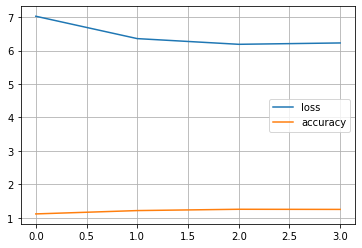

In [60]:
plt.plot(history["loss"], label='loss')
plt.plot(history["acc"], label='accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

In [61]:
# Help to build a prediction text for a multitask model
def multi_prediction_text_fn(outputs, idx):
  _, preds_gender = torch.max(outputs[0], 1)
  _, preds_race = torch.max(outputs[1], 1)
  return '{}, {}'.format(valid_ds.classes_gender[preds_gender[idx].item()], valid_ds.classes_race[preds_race[idx].item()])

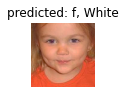

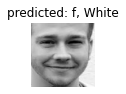

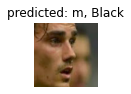

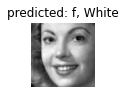

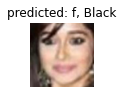

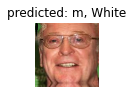

In [62]:
visualize_model(model_ft, multi_prediction_text_fn)